In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import scipy.signal as sgn
from scipy.optimize import minimize
from matplotlib.patches import Rectangle
from mpl_toolkits import mplot3d
import torch
# %matplotlib inline
# %matplotlib ipympl
# %matplotlib ipympl

In [2]:
def center_fn(led_pos: tuple, kcx: torch.tensor=torch.tensor([1.0859473, -0.000556592144, 5.48586221e-07]), kcy: torch.tensor=torch.tensor([1.09006337, -0.000365032841, 4.51764466e-07]), 
              origin: torch.tensor=torch.tensor((2758, 1219)), unit: torch.tensor=torch.tensor((202, 186)), center_led: torch.tensor=torch.tensor((15, 15))):

    rx, ry = (led_pos[0] - center_led[0])*unit[0], (30 - led_pos[1] - center_led[1])*unit[1]
    r = torch.sqrt(rx**2 + ry**2)
    r_arr = torch.pow(r, torch.arange(3))
    
    x_est = rx*sum(kcx*r_arr) + origin[0]
    y_est = ry*sum(kcy*r_arr) + origin[1]

    return (x_est, y_est)

In [3]:
def axis_min_fn(led_pos: tuple, kax0: torch.tensor=torch.tensor([2499.64063531, 0.18209488, 0.03107323, 2.88452691, -0.03847153, -0.02654681, -0.12702866, -0.02022648])):
    x1, y1 = led_pos
    return kax0[1]*x1 + kax0[2]*y1 + kax0[3]*(x1**2) + kax0[4]*(y1**2) + kax0[5]*x1*y1 + kax0[6]*(x1**3) + kax0[7]*(y1**3) + kax0[0]

def axis_max_fn(led_pos: tuple, kax1: torch.tensor=torch.tensor([2765.55044151, -6.83235681, -4.38549775, 0.02671118, 0.02110941, 0.28043923])):
    x1, y1 = led_pos
    return kax1[1]*x1 + kax1[2]*y1 + kax1[3]*x1**2 + kax1[4]*y1**2 + kax1[5]*x1*y1 + kax1[0]

def angle_fn(led_pos: tuple, kang: torch.tensor=torch.tensor([-93.08141194626909, 9.42944697, 1.31815639, 0.47404313, 0.33433636, -0.74189097])):
    x1, y1 = led_pos
    ang = kang[1]*x1 + kang[2]*y1 + kang[3]*x1**2 + kang[4]*y1**2 + kang[5]*x1*y1 + kang[0]
    return ang/180*3.14

In [4]:
def find_ellipse_params_from_extrap_fns(led_pos, 
                                        kcx: torch.tensor=torch.tensor([1.0859473, -0.000556592144, 5.48586221e-07]), 
                                        kcy: torch.tensor=torch.tensor([1.09006337, -0.000365032841, 4.51764466e-07]), 
                                        origin: torch.tensor=torch.tensor((2758, 1219)), unit: torch.tensor=torch.tensor((202, 186)),
                                        kax0: torch.tensor=torch.tensor([2499.64063531, 0.18209488, 0.03107323, 2.88452691, -0.03847153, -0.02654681, -0.12702866, -0.02022648]), 
                                        kax1: torch.tensor=torch.tensor([2765.55044151, -6.83235681, -4.38549775, 0.02671118, 0.02110941, 0.28043923]), 
                                        kang: torch.tensor=torch.tensor([-93.08141194626909, 9.42944697, 1.31815639, 0.47404313, 0.33433636, -0.74189097]),
                                        more_vars=False):
    
    if more_vars:
        # a = axis_max_fn_2(led_pos, kax1)
        # b = axis_min_fn_2(led_pos, kax0)
        # theta = angle_fn_2(led_pos, kang)
        # cx, cy = center_fn(led_pos, kcx, kcy, origin, unit)
        pass
    else:
        a = axis_max_fn(led_pos, kax1)
        b = axis_min_fn(led_pos, kax0)
        theta = angle_fn(led_pos, kang)
        cx, cy = center_fn(led_pos, kcx, kcy, origin, unit)

    A = (b**2)*torch.cos(theta)**2 + (a**2)*torch.sin(theta)**2
    B = (b**2 - a**2)*torch.sin(2*theta)
    C = (b**2)*torch.sin(theta)**2 + (a**2)*torch.cos(theta)**2
    D = -(2*A*cx + B*cy)
    E = -(2*C*cy + B*cx)
    F = A*cx**2 + C*cy**2 + B*cx*cy - (a**2)*(b**2)

    return ((a, b), (cx, cy), theta), (A, B, C, D, E, F)

In [7]:
def draw_cross(img, cord, color, length=50, thickness=10):
    
    x, y = int(cord[0]), int(cord[1])
    cv2.line(img, (x-length, y-length), (x+length, y+length), color, thickness)
    cv2.line(img, (x+length, y-length), (x-length, y+length), color, thickness)
    
    return img

In [5]:
OPT_PARAMS_CXY_COEFFS = torch.tensor((
    (
        1.0859e+00, -5.5658e-04, 5.2995e-07
    ),
    (
        1.0901e+00, -3.6503e-04, 4.5244e-07
    )

))

OPT_PARAMS_CXY_BIAS = torch.tensor((
    2758.0230, 1218.9767
))

# (MINOR, MAJOR)
OPT_PARAMS_AXIS= torch.tensor((
    (
        2.4996e+03, 1.8464e-01, 3.6049e-02, 2.8864e+00, -3.2558e-02, 
        -2.2786e-02, -1.2529e-01, -1.3723e-02, 0.0000e+00, 0.0000e+00
    ), 
    (
        2.7655e+03, -6.8554e+00, -4.4086e+00, 3.6593e-03, -2.1213e-03, 
        2.5728e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00
    )    
))

OPT_PARAMS_ANGLES = torch.tensor((
    -9.3076e+01, 9.4267e+00, 1.3283e+00, 4.6477e-01, 3.4690e-01,
    -7.3758e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00
))


In [81]:
angle_fn((x, y), OPT_PARAMS_ANGLES).detach().numpy()

array(1.4813694, dtype=float32)

In [143]:
x, y = 15, 15

x_cnt, y_cnt = center_fn(
            led_pos=(x, y), 
            kcx=OPT_PARAMS_CXY_COEFFS[0], 
            kcy=OPT_PARAMS_CXY_COEFFS[1], 
            origin=OPT_PARAMS_CXY_BIAS
            )

axis_lens_min = int(axis_min_fn((x, y), OPT_PARAMS_AXIS[0]).numpy())
axis_lens_maj = int(axis_max_fn((x, y), OPT_PARAMS_AXIS[1]).numpy())

ang = float(angle_fn((x, y), OPT_PARAMS_ANGLES).detach())

In [144]:
(int(x_cnt), int(y_cnt)), (int(axis_lens_maj), int(axis_lens_min)), ang

((2758, 1218), (2654, 2670), 1.4813693761825562)

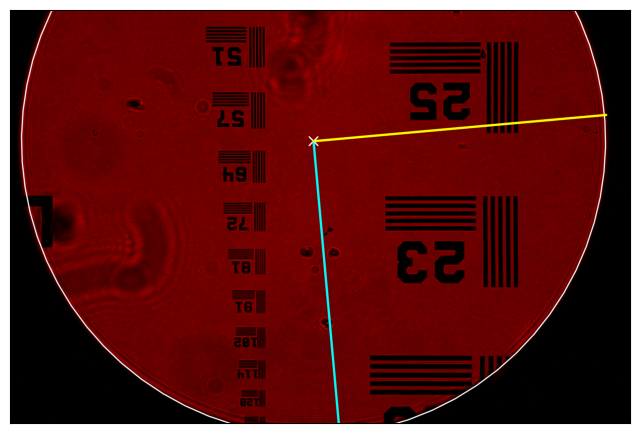

In [149]:
# x, y

dir_path = "Z:/CSE\CSE-Research/Microscopy3D/CV_CSE_Collaboration/Results/CV_CSE/fpm_capture/output/2023_03_15/2023_03_15_16_02_07/"
file_path = f"2023_03_15_16_02_07_img_shutter_05_x_{x}_y_{y}_r_1_g_0_b_0.tiff"

img = cv2.imread(dir_path + file_path, cv2.IMREAD_UNCHANGED)
b_img, g_img, r_img = cv2.split(img)

g_img_8 = cv2.convertScaleAbs(g_img, alpha=(255/65535))
b_img_8 = cv2.convertScaleAbs(b_img, alpha=(255/65535))
r_img_8 = cv2.convertScaleAbs(r_img, alpha=(255/65535))

temp = np.zeros_like(img, dtype=np.uint8)
temp[:, :, 0] = r_img_8

# y_cnt -= 20
plt.figure(figsize=(8,8))
draw_cross(temp, (int(x_cnt), int(y_cnt)), (255, 255, 255), length=40, thickness=10)
cv2.ellipse(temp, (int(x_cnt), int(y_cnt)), (axis_lens_maj, axis_lens_min), ang, 0, 360, (255, 255, 255), 10)

endpoint = (x_cnt + axis_lens_maj*np.cos(ang), y_cnt + axis_lens_maj*np.sin(ang))
cv2.line(temp, (int(x_cnt), int(y_cnt)), (int(endpoint[0]), int(endpoint[1])), (0, 255, 255), 20)

endpoint = (x_cnt + axis_lens_min*np.cos(np.abs(np.pi/2 - ang)), y_cnt - axis_lens_min*np.sin(np.abs(np.pi/2 - ang)))
cv2.line(temp, (int(x_cnt), int(y_cnt)), (int(endpoint[0]), int(endpoint[1])), (255, 255, 0), 20)

plt.imshow(temp)

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) #

plt.show()

In [76]:
endpoint

(tensor(116.3098), tensor(963.8918))

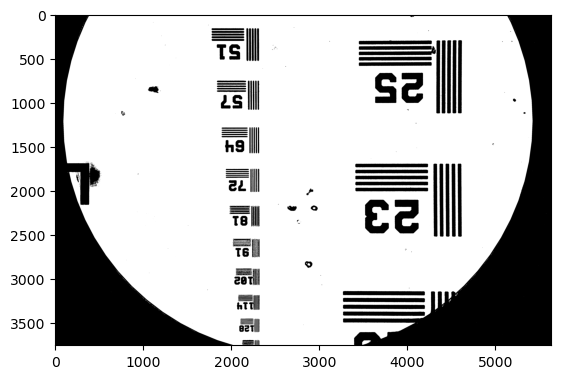

16985046.5


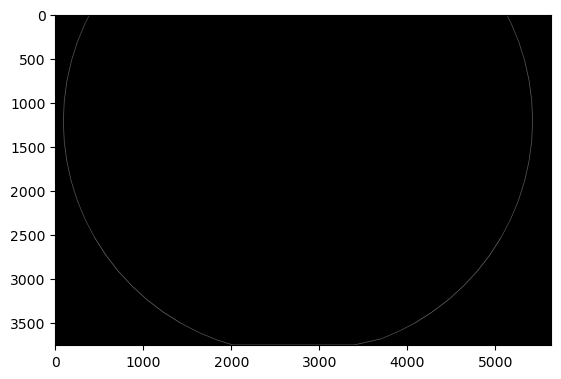

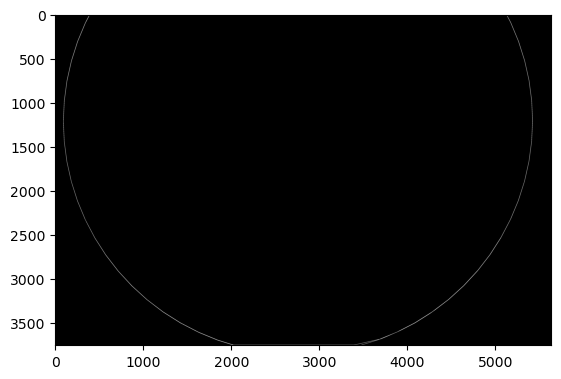

((2759.197998046875, 1213.6656494140625),
 (5280.08984375, 5329.38330078125),
 85.0787124633789)

In [68]:
ret, thresh = cv2.threshold(g_img_8, 50, 255, 0)
plt.imshow(thresh, cmap='gray')
plt.show()
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
blank = np.zeros_like(thresh)
# blank = np.zeros([6000, 6000])

area = []
for ind, cnt in enumerate(contours):
    area.append(cv2.contourArea(cnt))

print(area[np.argmax(np.array(area))])
cnt = contours[np.argmax(np.array(area))]
hull = cv2.convexHull(cnt)
cv2.drawContours(blank, [hull], 0, 255, 2)
plt.imshow(blank, cmap='gray')
plt.show()

ellipse = cv2.fitEllipse(hull)
cv2.ellipse(blank, ellipse, 255, 2)
plt.imshow(blank, cmap='gray')
plt.show()

ellipse

In [80]:
x_cnt, y_cnt, ang, ellipse[2]*np.pi/180

(tensor(2758.0229), tensor(1218.9767), 0.02585477305260007, 1.4849036558434974)

In [70]:
(5316.35693359375/2, 5348.74072265625/2)

(2658.178466796875, 2674.370361328125)

In [71]:
(int(ellipse[0][0]), int(ellipse[0][1])), (int(endpoint[0]), int(endpoint[1]))

((2759, 1213), (5416, 973))

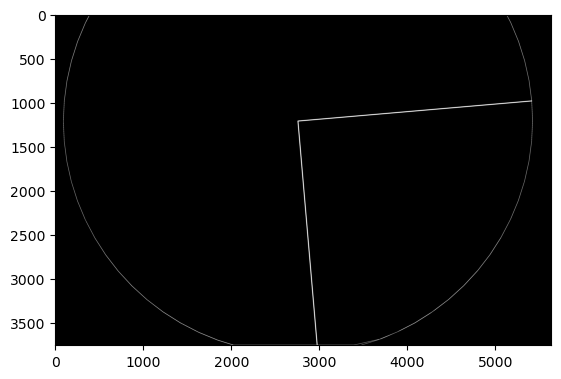

In [72]:
endpoint = (ellipse[0][0] + ellipse[1][0]/2*np.cos(ellipse[2]*np.pi/180), ellipse[0][1] + ellipse[1][0]/2*np.sin(ellipse[2]*np.pi/180))
cv2.line(blank, (int(ellipse[0][0]), int(ellipse[0][1])), (int(endpoint[0]), int(endpoint[1])), 255, 10)

endpoint = (ellipse[0][0] + ellipse[1][1]/2*np.cos(np.abs(90-ellipse[2])*np.pi/180), ellipse[0][1] - ellipse[1][1]/2*np.sin(np.abs(90-ellipse[2])*np.pi/180))
cv2.line(blank, (int(ellipse[0][0]), int(ellipse[0][1])), (int(endpoint[0]), int(endpoint[1])), 255, 10)

plt.imshow(blank, cmap='gray')